In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("bmh")
import tensorflow as tf
from tensorflow import keras
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import joblib
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from keras.metrics import RootMeanSquaredError
from pathlib import Path
from time import strftime
import xgboost as xgb
import missingno as msn
from sklearn.mixture import GaussianMixture

import shap

In [2]:
df = pd.read_csv("../../DATA/Data_increase.csv").drop(["Unnamed: 0","Unnamed: 0.1"], axis=1)
df["LLD-LLS"] = df.log_LLD - df.log_LLS
df["GR-GKUT"] = df.GR - df.GKUT
df.head()

,DEPT,GR,GKUT,NPHI,PE,RHOB,DRHO,well,log_LLS,log_LLD,LLD-LLS,GR-GKUT
0,2705.2524,19.0270,18.7281,0.0513,5.2064,2.6527,0.0198,1,0.699109,0.749381,0.050272,0.2989
1,2705.4048,15.8497,16.5070,0.0468,5.2632,2.6564,0.0229,1,0.708140,0.769960,0.061820,-0.6573
2,2705.5572,13.3455,14.3921,0.0411,5.2742,2.6546,0.0218,1,0.751779,0.823416,0.071636,-1.0466
3,2705.7096,12.2315,13.6969,0.0369,5.2543,2.6488,0.0202,1,0.787269,0.865447,0.078178,-1.4654
4,2705.8620,13.0494,13.2589,0.0322,5.1625,2.6475,0.0145,1,0.833886,0.921738,0.087852,-0.2095


In [3]:
train = df[~df['well'].isin(df.groupby("well").get_group(6)['well'])]
train = train[~train['well'].isin(train.groupby("well").get_group(4)['well'])]
test = df.groupby("well").get_group(6)
val = df.groupby("well").get_group(4)

X_train = train.drop(["NPHI", "RHOB","DRHO", "well"], axis=1)
y_train = train["NPHI"]

X_test = test.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)
y_test = test["NPHI"]

X_val = val.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)
y_val = val["NPHI"]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [4]:
def get_run_logdir(root_logdir="./logs/my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")
run_logdir = get_run_logdir()

In [5]:
class MLP_model(keras.Model):
    
    def __init__(self, number_hidden=10,units=np.ones(10)*30, activation=["relu" for i in range(10)], **kwargs):
        super().__init__(**kwargs) # needed to support naming the model
        
        #Normalization Layer
        self.norm_layer_deep = tf.keras.layers.Normalization()
        #how many dese Layers that we need
        for i in range(number_hidden):
            j = i+1
            globals()[f"self.hidden{j}"] = tf.keras.layers.Dense(units[i], activation[i],kernel_initializer='normal')
        #out put display
        self.output_ = tf.keras.layers.Dense(1,kernel_initializer='normal')
        self.layers_ = number_hidden
    def call(self, inputs):
        n_timesteps = inputs.shape[1] #13
        n_features  = inputs.shape[2] #1
        input_deep = tf.keras.layers.Input(shape=(n_timesteps,n_features))
        
        conve1D_1 = keras.layers.Conv1D(filters=512, kernel_size=4, padding='same',activation='relu', name="Conv1D_1")(input_deep)
        conve1D_2 = keras.layers.Conv1D(filters=256, kernel_size=4, padding='same', activation="relu", name="Conv1D_2")(conve1D_1)
        
        MaxPooling1D_1 = keras.layers.MaxPool1D(pool_size=2, name="MaxPooling1D_1")(conve1D_2)
        
        conve1D_3 = keras.layers.Conv1D(filters=128, kernel_size=4, padding='same', activation='relu', name="Conv1D_3")(MaxPooling1D_1)
        conve1D_4 = keras.layers.Conv1D(filters=64, kernel_size=4, padding='same', activation="relu", name="Conv1D_4")(conve1D_3)
        
        MaxPooling1D_2 = keras.layers.MaxPool1D(pool_size=2, name="MaxPooling1D_2")(conve1D_4)
        
        conve1D_5 = keras.layers.Conv1D(filters=32, kernel_size=4, padding='same', activation='relu', name="Conv1D_5")(MaxPooling1D_2)
        conve1D_6 = keras.layers.Conv1D(filters=32, kernel_size=4, padding='same', activation="relu", name="Conv1D_6")(conve1D_5)
        
        MaxPooling1D_3 = keras.layers.MaxPool1D(pool_size=2, padding='same', name="MaxPooling1D_3")(conve1D_6)
        
        flatten = keras.layers.Flatten()(MaxPooling1D_3)
        
        norm_deep = self.norm_layer_deep(input_deep)
        for i in range(self.layers_):
            
            if i==0:
                globals()[f"hidden{1}"] = globals()[f"self.hidden{1}"](flatten)
                globals()[f"drop_out{1}"] = tf.keras.layers.Dropout(0.3)(globals()[f"hidden{1}"])
                globals()[f"normalize{1}"] = tf.keras.layers.BatchNormalization()(globals()[f"drop_out{1}"])
                
            else:
                globals()[f"hidden{i+1}"] = globals()[f"self.hidden{i+1}"](globals()[f"hidden{i}"])
                globals()[f"drop_out{i+1}"] = tf.keras.layers.Dropout(0.3)(globals()[f"hidden{i+1}"])
                globals()[f"normalize{i+1}"] = tf.keras.layers.BatchNormalization()(globals()[f"drop_out{i+1}"])
       
        main_output = self.output_(globals()[f"hidden{self.layers_}"])
        model_ = tf.keras.Model(inputs=input_deep, outputs=main_output)
        return model_



Epoch 1/1000

93/93 [==============================] - 8s 55ms/step - loss: 0.0074 - root_mean_squared_error: 0.0860 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0555
Epoch 2/1000
93/93 [==============================] - 4s 48ms/step - loss: 0.0017 - root_mean_squared_error: 0.0414 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0395
Epoch 3/1000
93/93 [==============================] - 5s 52ms/step - loss: 0.0013 - root_mean_squared_error: 0.0359 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0367
Epoch 4/1000
93/93 [==============================] - 4s 48ms/step - loss: 0.0012 - root_mean_squared_error: 0.0341 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0366
Epoch 5/1000
93/93 [==============================] - 5s 49ms/step - loss: 0.0011 - root_mean_squared_error: 0.0328 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0356
Epoch 6/1000
93/93 [==============================] - 4s 48ms/step - loss: 0.0010 - root_mean_squared_error: 0.0321 - val_loss: 0.00

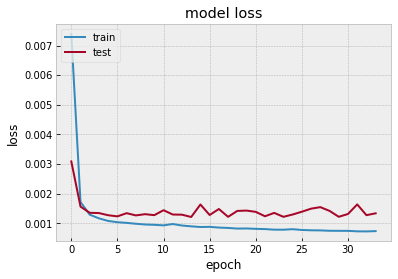

In [5]:
# X_train, y_train = X_train.values, y_train.values
# X_test, y_test = X_test.values, y_test.values
model_befor = MLP_model(number_hidden=10,units=[50 for i in range(50)], activation=["relu" for i in range(50)], name="my_cool_model")
X_train_cnn, X_test_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1), X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val_cnn = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
model = model_befor.call(X_train_cnn)
optimizer =keras.optimizers.Adamax()
model.compile(loss="mse", optimizer=optimizer, metrics=[RootMeanSquaredError()])

def get_run_logdir(root_logdir="./logs/my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")
run_logdir = get_run_logdir()

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,profile_batch=(100, 200))
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(f"cnn_model.h5", save_weights_only=True,best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

history = model.fit(X_train_cnn, y_train,
                batch_size=161,
                callbacks=[early_stopping_cb,checkpoint_cb, tensorboard_cb],
                validation_data=(X_val_cnn, y_val),
                epochs=1000,
                verbose=1)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

model.save_weights(f"model.h5")

In [6]:
model_befor = MLP_model(number_hidden=10,units=[50 for i in range(50)], activation=["relu" for i in range(50)], name="my_cool_model")
X_train_cnn, X_test_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1), X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val_cnn = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
model = model_befor.call(X_train_cnn)
optimizer =keras.optimizers.Adamax()
model.compile(loss="mse", optimizer=optimizer, metrics=[RootMeanSquaredError()])

model.load_weights("cnn_model.h5")

In [7]:
print("best_model:R2")
print(r2_score(y_train, model.predict(X_train)))
print(mean_absolute_error(y_train, model.predict(X_train)))
print(mean_squared_error(y_train, model.predict(X_train)))

best_model:R2
466/466 [==============================] - 3s 5ms/step
0.820634520478277
466/466 [==============================] - 2s 5ms/step
0.021519789624272798
466/466 [==============================] - 2s 5ms/step
0.0008655547755964638


In [8]:
print("best_model:R2")
print(r2_score(y_test, model.predict(X_test)))
print(mean_absolute_error(y_test, model.predict(X_test)))
print(mean_squared_error(y_test, model.predict(X_test)))

best_model:R2
43/43 [==============================] - 0s 5ms/step
0.7604459128674754
43/43 [==============================] - 0s 5ms/step
0.02277621537258103
43/43 [==============================] - 0s 5ms/step
0.0009553595175257539


In [9]:
print("best_model:R2")
print(r2_score(y_val, model.predict(X_val)))
print(mean_absolute_error(y_val, model.predict(X_val)))
print(mean_squared_error(y_val, model.predict(X_val)))

best_model:R2
38/38 [==============================] - 0s 5ms/step
0.6465169989165407
38/38 [==============================] - 0s 5ms/step
0.026317777687668655
38/38 [==============================] - 0s 5ms/step
0.0012085988296549313


43/43 [==============================] - 0s 5ms/step


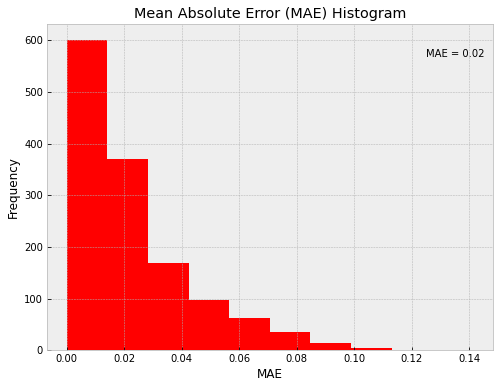

In [10]:
# Calculate the Mean Absolute Error (MAE)
y_pred = model.predict(X_test)
mae = np.abs(y_test - np.reshape(y_pred,(np.shape(y_pred)[0],)))
MAE = np.sum(mae)/(len(y_pred))
# Plot the MAE histogram
plt.figure(figsize=(8, 6))
plt.hist(mae, color="r")
# , bins=3, edgecolor='red'
plt.xlabel('MAE')
plt.ylabel('Frequency')
plt.title('Mean Absolute Error (MAE) Histogram')
plt.text(0.85, 0.9, f"MAE = {MAE:.2f}", transform=plt.gca().transAxes)
plt.savefig("MAE.png")
plt.show()

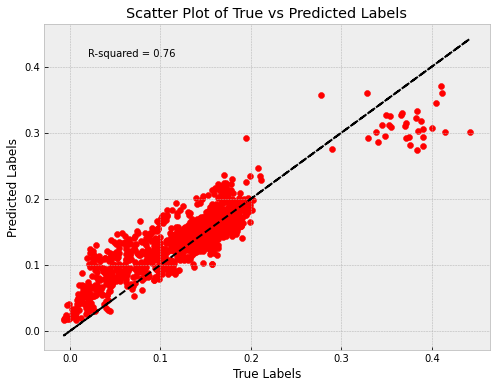

In [11]:
# y_pred = np.reshape(y_pred,(1357,))
# Plot the scatter plot
r2 = r2_score(y_test, y_pred)
plt.figure(figsize=(8, 6))

plt.plot(y_test,y_test, linestyle = 'dashed', color="black")
plt.scatter(y_test, y_pred, color="r")
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Scatter Plot of True vs Predicted Labels')
plt.text(0.1, 0.9, f"R-squared = {r2:.2f}", transform=plt.gca().transAxes)
plt.savefig("sctatter.png")
plt.show()

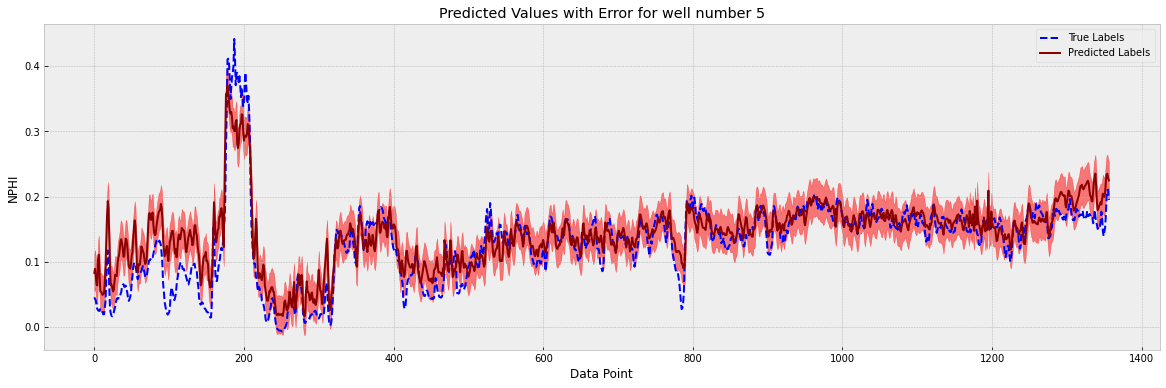

In [12]:
y_pred = np.reshape(y_pred, (1357,))
y_true = y_test.values
# Calculate the error between true and predicted labels
error = y_true - y_pred

# Plot the predicted values and error
plt.figure(figsize=(20, 6))
plt.plot(y_true, label='True Labels', color="b", alpha=1, linestyle = 'dashed')
plt.plot(y_pred, label='Predicted Labels', color="darkred")
plt.fill_between(range(len(y_true)), y_pred-0.029, y_pred+0.029, alpha=0.5, color='red')

plt.xlabel('Data Point')
plt.ylabel('NPHI')
plt.title('Predicted Values with Error for well number 5')
plt.legend()
plt.savefig("plot.png")
plt.show()

In [13]:
well1 = df.groupby("well").get_group(1)
well2 = df.groupby("well").get_group(2)
well3 = df.groupby("well").get_group(3)
well4 = df.groupby("well").get_group(4)
well6 = df.groupby("well").get_group(6)
well7 = df.groupby("well").get_group(7)



NPHI1_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI2_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI3_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI4_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI5_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI6_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])


NPHI1_log["DEPT"], NPHI1_log["well_NPHI"], NPHI1_log["well_pridct"] = well1["DEPT"], well1["NPHI"], model.predict(scaler.transform(well1.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI2_log["DEPT"], NPHI2_log["well_NPHI"], NPHI2_log["well_pridct"] = well2["DEPT"], well2["NPHI"], model.predict(scaler.transform(well2.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI3_log["DEPT"], NPHI3_log["well_NPHI"], NPHI3_log["well_pridct"] = well3["DEPT"], well3["NPHI"], model.predict(scaler.transform(well3.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI4_log["DEPT"], NPHI4_log["well_NPHI"], NPHI4_log["well_pridct"] = well4["DEPT"], well4["NPHI"], model.predict(scaler.transform(well4.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI5_log["DEPT"], NPHI5_log["well_NPHI"], NPHI5_log["well_pridct"] = well6["DEPT"], well6["NPHI"], model.predict(scaler.transform(well6.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI6_log["DEPT"], NPHI6_log["well_NPHI"], NPHI6_log["well_pridct"] = well7["DEPT"], well7["NPHI"], model.predict(scaler.transform(well7.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))





NPHIs_log = [NPHI1_log,
             NPHI2_log,
             NPHI3_log,
             NPHI4_log,
             NPHI5_log,
             NPHI6_log]

59/59 [==============================] - 0s 5ms/step


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose l

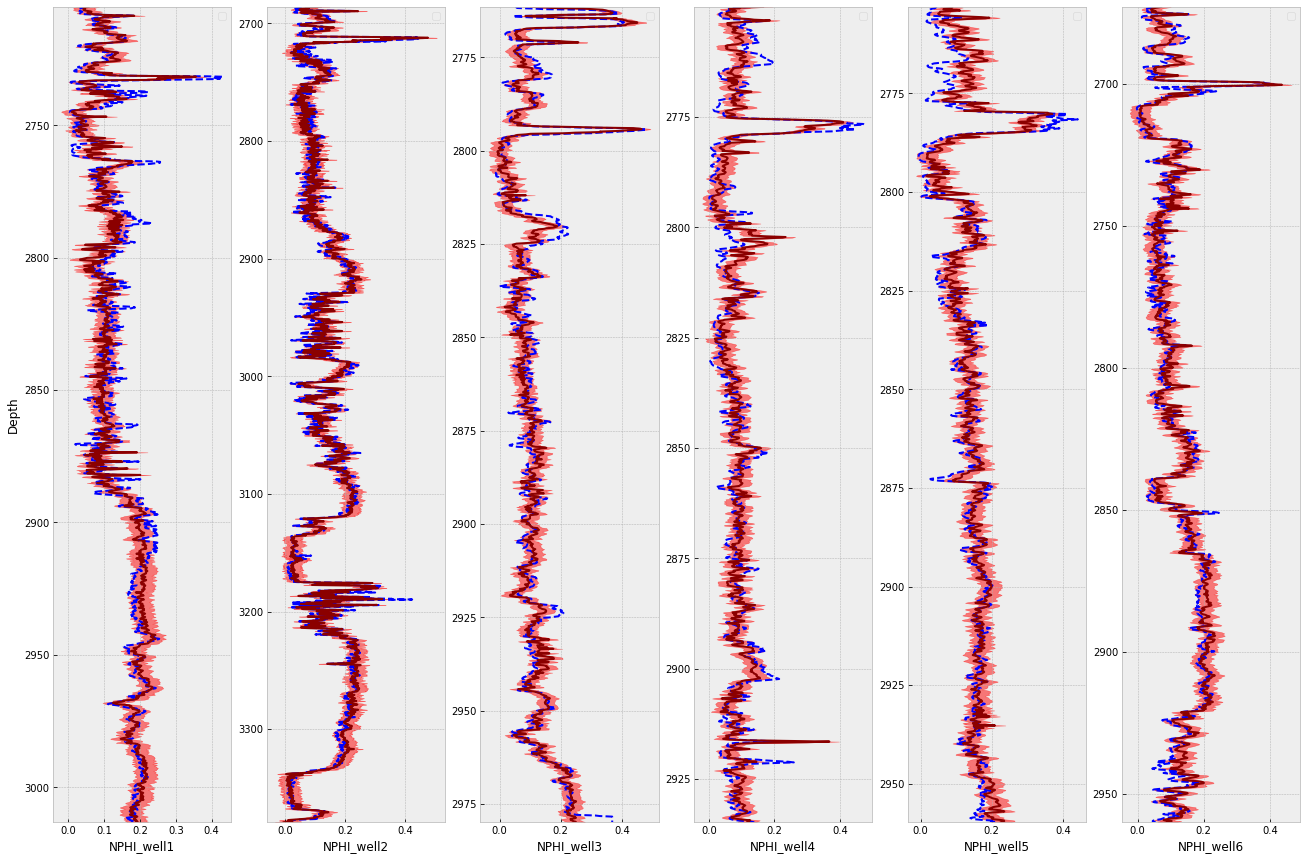

In [14]:
fig, axes = plt.subplots(figsize=(30,15), sharey=True)

for i, logs in enumerate(NPHIs_log):
    globals()['axes{}'.format(i)] = plt.subplot2grid((1,8), (0,i), rowspan=1, colspan = 1) 
    globals()['axes{}'.format(i)].plot(logs["well_NPHI"].values, logs["DEPT"].values, color="b", alpha=1, linestyle='dashed')
    globals()['axes{}'.format(i)].plot(logs["well_pridct"].values, logs["DEPT"].values, color="darkred")
    globals()['axes{}'.format(i)].fill_betweenx(logs["DEPT"].values, logs["well_pridct"].values-0.029, logs["well_pridct"].values+0.029, alpha=0.5, color='red')
    globals()['axes{}'.format(i)].set_xlabel(f"NPHI_well{i+1}")
    globals()['axes{}'.format(i)].legend()
    globals()['axes{}'.format(i)].set_ylim(logs["DEPT"].max(), logs["DEPT"].min())

axes0.set_ylabel('Depth')
plt.savefig("all_wells.png")
plt.show()

ExactExplainer explainer: 1358it [29:13,  1.30s/it]                                                                    


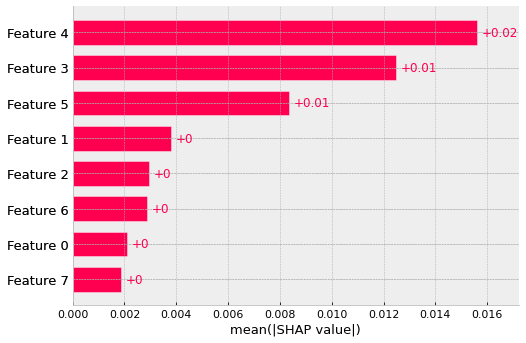

In [15]:
# compute SHAP values
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)
shap.plots.bar(shap_values)

In [25]:
import shap
# Initialize the SHAP explainer
explainer = shap.Explainer(model5, X_train.values)

# Compute the SHAP values
shap_values = explainer(X_train.values)

ExactExplainer explainer: 11105it [1:57:27,  1.57it/s]                                                                 


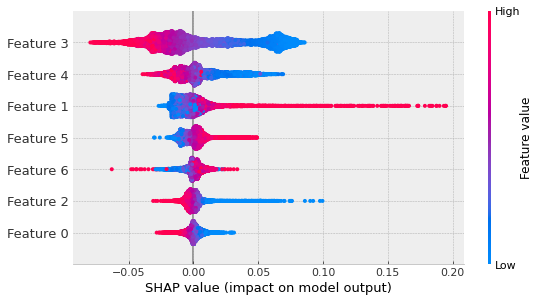

In [26]:
# Plot the SHAP values
shap.summary_plot(shap_values, X_train.values)


In [17]:
train = df[~df['well'].isin(df.groupby("well").get_group(2)['well'])]
test = df.groupby("well").get_group(2)


X_train = train.drop(["NPHI", "RHOB","DRHO", "well"], axis=1).values
y_train = train["NPHI"].values

X_test = test.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1).values
y_test = test["NPHI"].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

Epoch 1/1000
81/81 [==============================] - 7s 57ms/step - loss: 0.0084 - root_mean_squared_error: 0.0918 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0581
Epoch 2/1000
81/81 [==============================] - 4s 51ms/step - loss: 0.0020 - root_mean_squared_error: 0.0449 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0333
Epoch 3/1000
81/81 [==============================] - 5s 56ms/step - loss: 0.0015 - root_mean_squared_error: 0.0386 - val_loss: 9.8345e-04 - val_root_mean_squared_error: 0.0314
Epoch 4/1000
81/81 [==============================] - 4s 53ms/step - loss: 0.0013 - root_mean_squared_error: 0.0361 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0323
Epoch 5/1000
81/81 [==============================] - 4s 54ms/step - loss: 0.0012 - root_mean_squared_error: 0.0345 - val_loss: 8.1335e-04 - val_root_mean_squared_error: 0.0285
Epoch 6/1000
81/81 [==============================] - 4s 52ms/step - loss: 0.0012 - root_mean_squared_error: 0.0340 - val_loss:

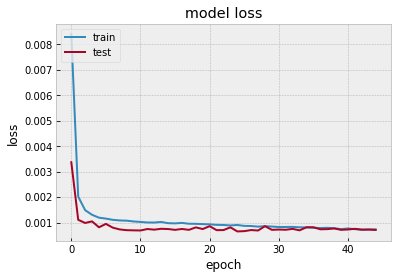

In [19]:
# X_train, y_train = X_train.values, y_train.values
# X_test, y_test = X_test.values, y_test.values
model_befor = MLP_model(number_hidden=10,units=[50 for i in range(50)], activation=["relu" for i in range(50)], name="my_cool_model")
X_train_cnn, X_test_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1), X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
model = model_befor.call(X_train_cnn)
optimizer =keras.optimizers.Adamax()
model.compile(loss="mse", optimizer=optimizer, metrics=[RootMeanSquaredError()])

def get_run_logdir(root_logdir="./logs/my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")
run_logdir = get_run_logdir()

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,profile_batch=(100, 200))
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(f"cnn_model.h5", save_weights_only=True,best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

history = model.fit(X_train_cnn, y_train,
                batch_size=161,
                callbacks=[early_stopping_cb,checkpoint_cb, tensorboard_cb],
                validation_data=(X_test_cnn, y_test),
                epochs=1000,
                verbose=1)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

model.save_weights(f"model.h5")

In [20]:
print(r2_score(y_test, model.predict(X_test)))

143/143 [==============================] - 1s 5ms/step
0.8760949746482356


143/143 [==============================] - 1s 6ms/step


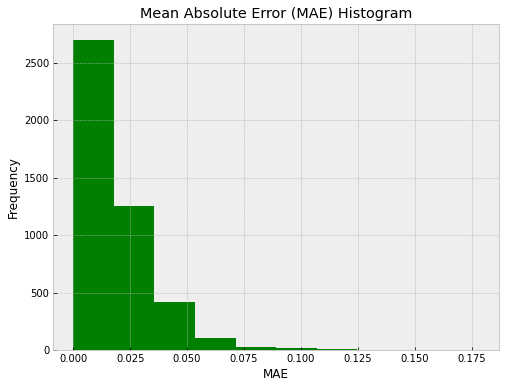

In [21]:
# Calculate the Mean Absolute Error (MAE)
y_pred = model.predict(X_test)
mae = np.abs(y_test - np.reshape(y_pred,y_pred.shape[0]))

# Plot the MAE histogram
plt.figure(figsize=(8, 6))
plt.hist(mae, color="green")
# , bins=3, edgecolor='red'
plt.xlabel('MAE')
plt.ylabel('Frequency')
plt.title('Mean Absolute Error (MAE) Histogram')
plt.show()

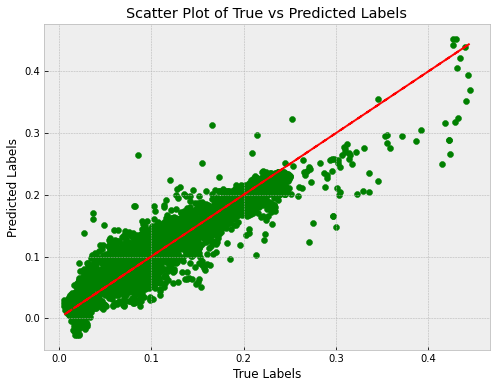

In [22]:
y_pred = np.reshape(y_pred,y_pred.shape[0])
# Plot the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color="green")
plt.plot(y_test,y_test, linestyle = 'dashed', color="red")
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Scatter Plot of True vs Predicted Labels')
plt.show()

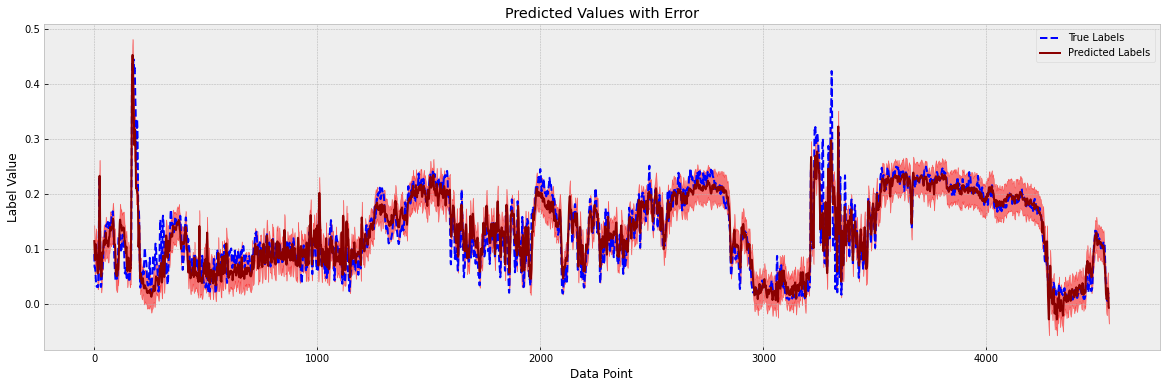

In [23]:
y_true = y_test
# Calculate the error between true and predicted labels
error = y_true - y_pred

# Plot the predicted values and error
plt.figure(figsize=(20, 6))
plt.plot(y_true, label='True Labels', color="b", alpha=1, linestyle = 'dashed')
plt.plot(y_pred, label='Predicted Labels', color="darkred")
plt.fill_between(range(len(y_true)), y_pred-0.029, y_pred+0.029, alpha=0.5, color='red')

plt.xlabel('Data Point')
plt.ylabel('Label Value')
plt.title('Predicted Values with Error')
plt.legend()
plt.show()

In [24]:
well1 = df.groupby("well").get_group(1)
well2 = df.groupby("well").get_group(2)
# well3 = df.groupby("well").get_group(3)
well4 = df.groupby("well").get_group(4)
well6 = df.groupby("well").get_group(6)
well7 = df.groupby("well").get_group(7)



NPHI1_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI2_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI3_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI4_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI5_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])
NPHI6_log = pd.DataFrame(columns=["DEPT", "well_NPHI", "well_pridct"])


NPHI1_log["DEPT"], NPHI1_log["well_NPHI"], NPHI1_log["well_pridct"] = well1["DEPT"], well1["NPHI"], model.predict(scaler.transform(well1.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI2_log["DEPT"], NPHI2_log["well_NPHI"], NPHI2_log["well_pridct"] = well2["DEPT"], well2["NPHI"], model.predict(scaler.transform(well2.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI3_log["DEPT"], NPHI3_log["well_NPHI"], NPHI3_log["well_pridct"] = well3["DEPT"], well3["NPHI"], model.predict(scaler.transform(well3.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI4_log["DEPT"], NPHI4_log["well_NPHI"], NPHI4_log["well_pridct"] = well4["DEPT"], well4["NPHI"], model.predict(scaler.transform(well4.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI5_log["DEPT"], NPHI5_log["well_NPHI"], NPHI5_log["well_pridct"] = well6["DEPT"], well6["NPHI"], model.predict(scaler.transform(well6.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))
NPHI6_log["DEPT"], NPHI6_log["well_NPHI"], NPHI6_log["well_pridct"] = well7["DEPT"], well7["NPHI"], model.predict(scaler.transform(well7.drop(["NPHI", "RHOB", "DRHO", "well"], axis=1)))





NPHIs_log = [NPHI1_log,
             NPHI2_log,
             NPHI3_log,
             NPHI4_log,
             NPHI5_log,
             NPHI6_log]

19/64 [=======>......................] - ETA: 0s

C:\Users\Ariyana-Soft\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


 19/143 [==>...........................] - ETA: 0s

C:\Users\Ariyana-Soft\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


30/45 [===================>..........] - ETA: 0s

C:\Users\Ariyana-Soft\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


19/38 [==============>...............] - ETA: 0s

C:\Users\Ariyana-Soft\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


19/43 [============>.................] - ETA: 0s

C:\Users\Ariyana-Soft\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


19/59 [========>.....................] - ETA: 0s

C:\Users\Ariyana-Soft\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


59/59 [==============================] - 0s 6ms/step


C:\Users\Ariyana-Soft\AppData\Local\Temp\ipykernel_10860\1398524346.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  globals()['axes{}'.format(i)] = plt.subplot2grid((1,8), (0,i), rowspan=1, colspan = 1)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put i

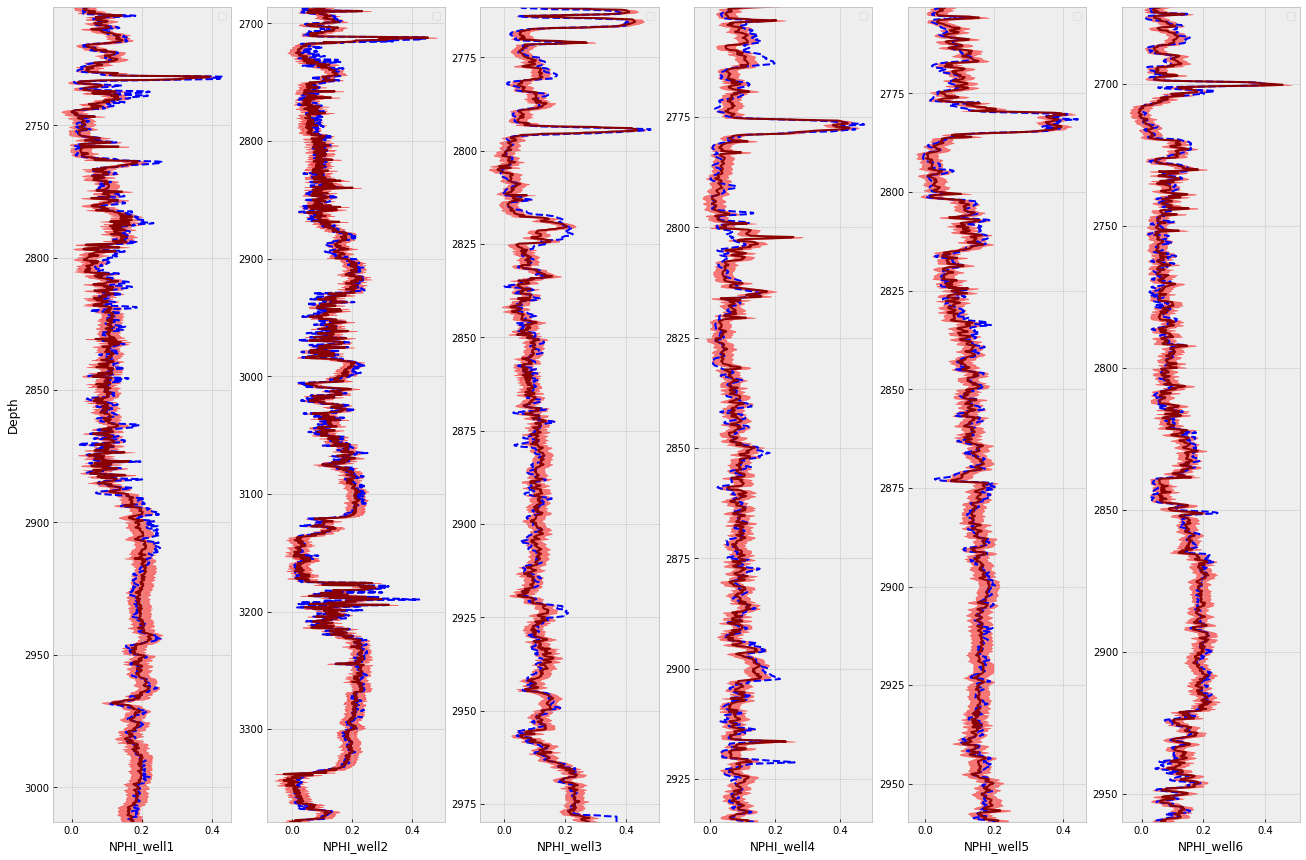

In [25]:
fig, axes = plt.subplots(figsize=(30,15), sharey=True)

for i, logs in enumerate(NPHIs_log):
    globals()['axes{}'.format(i)] = plt.subplot2grid((1,8), (0,i), rowspan=1, colspan = 1) 
    globals()['axes{}'.format(i)].plot(logs["well_NPHI"].values, logs["DEPT"].values, color="b", alpha=1, linestyle='dashed')
    globals()['axes{}'.format(i)].plot(logs["well_pridct"].values, logs["DEPT"].values, color="darkred")
    globals()['axes{}'.format(i)].fill_betweenx(logs["DEPT"].values, logs["well_pridct"].values-0.029, logs["well_pridct"].values+0.029, alpha=0.5, color='red')
    globals()['axes{}'.format(i)].set_xlabel(f"NPHI_well{i+1}")
    globals()['axes{}'.format(i)].legend()
    globals()['axes{}'.format(i)].set_ylim(logs["DEPT"].max(), logs["DEPT"].min())

axes0.set_ylabel('Depth')

plt.show()

In [29]:
# Initialize the SHAP explainer
explainer = shap.Explainer(model, X_train)

# Compute the SHAP values
shap_values = explainer(X_train)

ExactExplainer explainer: 12912it [4:38:20,  1.29s/it]                                                                 


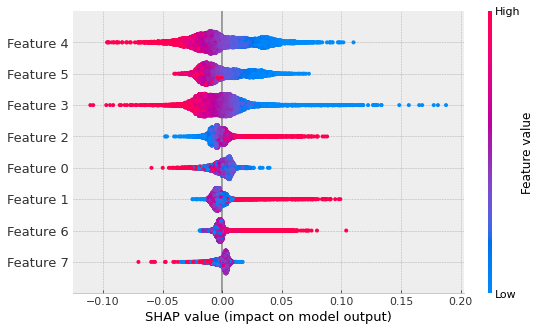

In [30]:
# Plot the SHAP values
shap.summary_plot(shap_values, X_train)